In [36]:
import numpy as np
import scipy as sc
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
from EBL_fit_MC_functions import *
from scipy.stats import norm
from scipy.stats import poisson
import yaml
import matplotlib.pyplot as plt
import h5py
import time
import sys
import os
import uproot
from scipy.stats import norm, chi2
from pathlib import Path

In [37]:
systematics = 0.07
Emin = 0.06
Emax = 15.

#load all config from config file:
start_time = time.time()
with open("/home/rgrau/Desktop/EBL-splines/EBL_fit_config2_1.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
niter = inp_config["niter"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]
LP_curvature = inp_config["LP_curvature"]
Source_z = inp_config["Source_z"]

if fit_func_name == "MBPWL":
    knots = inp_config["knots"]
    Efirst = inp_config["Efirst"]
    DeltaEbr = inp_config["DeltaE"]
else:
    knots = 3
    Efirst = 3
    DeltaEbr = 3

#define fit function depending on the selected one in the configuration:
fit_func = fit_func_select(fit_func_name, knots, Efirst, DeltaEbr)

if Forward_folding:
    if Telescope == "CTAN_alpha": #this part needs to be changed to include the real CTAN_alpha configuration
        Noffregions = 5
        def m2LogL(params):
            xdata = E_EBL
            mtau = -tau
            mu_gam0 = dNdE_to_mu((fit_func(xdata, params) * np.exp(mtau * alpha))[2:37], Effa_reb, Ebinsw[2:37], Observation_time, Ebins, Eres_reb2, E_EBL[2:37])
            mu_gam = mu_gam0[5:-4]
            mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
            min_num_gauss = 20
            conditions = [((Non >= min_num_gauss) & (Noff >= min_num_gauss)), (Non == 0.), (Noff == 0.), (Non != 0.) & (Noff != 0.)]
            choices = [Gauss_logL(Non, Noff, mu_gam, Noffregions), Poisson_logL_Non0(Non, Noff, mu_gam, Noffregions), Poisson_logL_Noff0(Non, Noff, mu_gam, Noffregions), Poisson_logL(Non, Noff, mu_gam, mu_bg, Noffregions)]
            res = np.select(conditions, choices, default = 999999999)
            return np.sum(res)
            
    elif Telescope == "MAGIC":
        Noffregions = 3
        def m2LogL(params):
            xdata = Etrue
            mtau = -tau
            mu_gam = dNdE_to_mu_MAGIC((fit_func(xdata, params) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, Eest)
            mu_gam_final = mu_gam[minbin:maxbin]
            Non_final = Non[minbin:maxbin] 
            Noff_final = Noff[minbin:maxbin]
            mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
            mu_bg_final = mu_bg[minbin:maxbin]
            min_num_gauss = 20
            conditions = [((Non_final >= min_num_gauss) & (Noff_final >= min_num_gauss)), (Non_final == 0.), (Noff_final == 0.), (Non_final != 0.) & (Noff_final != 0.)]
            choices = [Gauss_logL(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL_Non0(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL_Noff0(Non_final, Noff_final, mu_gam_final, Noffregions), Poisson_logL(Non_final, Noff_final, mu_gam_final, mu_bg_final, Noffregions)]
            res = np.select(conditions, choices, default = 999999999)
            return np.sum(res)

    def fit(initial_guess):
        
        
        m2LogL.errordef = Minuit.LIKELIHOOD
        m = Minuit(m2LogL, initial_guess)
        if fit_func_name == "MBPWL": #defines limits to faster and better find the minimum. Can be changed if the intrinsic spectrum function is changed.
            MBPWL_limits = ([(1e-6, 1e-3), (-4., 5.)])
            errors = [1e-7, 0.01]
            for i in range(knots):
                MBPWL_limits.append((0., 5.))
                errors.append(0.01)
            m.limits = MBPWL_limits
        elif fit_func_name == "PWL":
            m.limits = ([(1e-7,1e-3), None]) #TODO canviar això al codi principal
            errors = [1e-7, 0.01]
        else:
            m.limits = ([(1e-7, 1e-3), (-2., None), (None, None)])#FIXME canviar -2
            errors = [1e-07, 0.01, 0.01]
        # m.tol = 1e-15
        # m.strategy = 2
        m.errors = errors
        
        m.migrad()
        return m

else:
    def LSQ(params):
        return np.sum((ydata - fit_func(xdata, params)) ** 2 / ydata_u ** 2)

    def fit(initial_guess):
        LSQ.errordef = Minuit.LIKELIHOOD

        m = Minuit(LSQ, initial_guess)

        m.tol = 1e-20

        m.migrad()
        return m

if EBL_Model == "Dominguez": #loads the EBL data of the Dominguez et al 2011 paper.
    file = np.loadtxt('/home/rgrau/Desktop/EBL-splines/tau_dominguez11.out')
    pdfile = pd.DataFrame(file)
    pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
    E_EBL = pdfile['E [TeV]'].to_numpy() #energy bins
    tau_EBL = pdfile['tau z=0.20842105'].to_numpy() #tau bins
else:
    raise Exception('The EBL model "{func}" has not been implemented.'.format(func = EBL_Model))

if Spectrum_func_name == "PWL": #define the intrinsic spectrum if the function is a Power-Law
    def dNdE_absorbed(K, E, Norm, Ph_index, b, tau):
        dNdE = K / ((E/Norm)**Ph_index)
        m_tau = -tau
        return dNdE * np.exp(m_tau)

elif Spectrum_func_name == "LP": #define the intrinsic spectrum if the function is a Log-Parabola
    def dNdE_absorbed(K, E, Norm, Ph_index, b, tau):
        dNdE = K / ((E/Norm)**(Ph_index + (b * np.log(E/Norm))))
        m_tau = -tau
        return dNdE * np.exp(m_tau)

else:
    raise Exception('The simulated spectrum "{func}" has not been implemented.'.format(func = Spectrum_func_name))

if Telescope == "CTAN_alpha": #compute the values we need if the telescope selected is CTAN_alpha (needs to be changed as the Response function has to be changed)
    #Effective area:
    fileEA = np.loadtxt('/home/rgrau/Desktop/EBL-splines/EffArea50h.txt', skiprows = 11)
    EffA = pd.DataFrame(fileEA)
    EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
    EffaE= EffA['E [TeV]'].to_numpy()
    Effa = EffA['Eff area (m^2)'].to_numpy()

    Effa_reb = normal_interp1d(EffaE, Effa, E_EBL[2:37])


    #Anglular resolution:
    fileAng = np.loadtxt('/home/rgrau/Desktop/EBL-splines/Angres.txt', skiprows = 11)
    Angresall = pd.DataFrame(fileAng)
    Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
    AngresE = Angresall['E [TeV]'].to_numpy()
    Angres = Angresall['Angular resolution (deg)'].to_numpy()
    logE = np.log10(E_EBL)

    Angres_reb = log_interp1d(AngresE, Angres, E_EBL[2:37])

    #Background:
    fileBkg = np.loadtxt('/home/rgrau/Desktop/EBL-splines/Bkg50h.txt', skiprows = 10)
    Bkgpd = pd.DataFrame(fileBkg)
    Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

    BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
    BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
    Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
    BckgEdiff = BckgEmax - BckgEmin

    BckgElogmean = np.power(10 ,np.mean([np.log10(BckgEmax), np.log10(BckgEmin)], axis = 0))

    Ebinsmin = np.zeros(len(E_EBL))
    Ebinsmax = np.zeros(len(E_EBL))

    for i in range(1, len(E_EBL)):
        Ebinsmin[i] = 10**(np.mean([np.log10(E_EBL[i]), np.log10(E_EBL[i-1])]))
    for i in range(len(E_EBL) - 1):
        Ebinsmax[i] = 10**(np.mean([np.log10(E_EBL[i]), np.log10(E_EBL[i+1])]))
        
    Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
    Ebinsmax[len(E_EBL)-1] = 10**(np.log10(Ebinsmax[len(E_EBL)-2])-(np.log10(Ebinsmax[len(E_EBL)-3])-np.log10(Ebinsmax[len(E_EBL)-2])))
    Ebinsw = Ebinsmax - Ebinsmin
    DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2

    interpolation_bckg = log_interp1d2(BckgElogmean,DifBckg)

    Bckg_reb = np.zeros([len(E_EBL[2:37]),2])
    for i in range(len(E_EBL[2:37])):
        Bckg_reb[i] = quad(interpolation_bckg, Ebinsmin[i+2], Ebinsmax[i+2])
    Bckg_reb = Bckg_reb[:,0]

    #Treating the data:
    skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(np.deg2rad(Angres_reb)))#deg^2
    bckgmu = Bckg_reb * Observation_time * skyang

    ##Generating dNdE_absorved and applying Eres to it
    if Spectrum_func_name == "PWL":
        dNdEa = dNdE_absorbed(Source_flux, E_EBL, Norm, Ph_index, tau_EBL)

    elif Spectrum_func_name == "LP":
        dNdEa = dNdE_absorbed(Source_flux, E_EBL, Norm, Ph_index, LP_curvature, tau_EBL)
    
    
    logEbins = np.zeros(len(E_EBL[2:37])+1)
    for i in range(len(E_EBL[2:37])+1):
        if i == 0:
            logEbins[i] = logE[2] - ((logE[3]-logE[2])/2)
        elif i == (len(E_EBL[2:37])):
            logEbins[i] = logE[2:37][i-1] + ((logE[2:37][i-1]-logE[2:37][i-2])/2)
        else:
            logEbins[i] = (logE[2:37][i] + logE[2:37][i-1]) / 2

    Ebins = 10 ** logEbins
    #Energy Resolution:

    if Energy_migration:

        fileEres = np.loadtxt('/home/rgrau/Desktop/EBL-splines/Eres.txt', skiprows = 8)
        Eresall = pd.DataFrame(fileEres)
        Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
        EresE = Eresall['E [TeV]'].to_numpy()
        Eres = Eresall['Energy resolution (deg)'].to_numpy()

        Eres_reb = log_interp1d(EresE[:-1], Eres[:-1], E_EBL[2:37])
        Eres_reb2 = Eres_reb * E_EBL[2:37]
        
        mu_vec_reco = dNdE_to_mu(dNdEa[2:37], Effa_reb, Ebinsw[2:37], Observation_time, Ebins, Eres_reb2, E_EBL[2:37])
    else:
        mu_vec_reco = dNdEa[2:37] * Effa_reb * Ebinsw[2:37] * Observation_time

    E_final = E_EBL[7:33] #[7:33]
    mu_vec_final = mu_vec_reco[5:-4] #[5:-4]
    bckgmu_final = bckgmu[5:-4] * Background_scale
    Effa_final = Effa_reb[5:-4]
    Ebinsw_final = Ebinsw[7:33]
    tau = tau_EBL[7:33]

elif Telescope == "MAGIC": #compute values needed for minimization if the selected telescope is MAGIC
    
    Bckg = uproot.open("/home/rgrau/Desktop/EBL-splines/Output_flute.root:hEstBckgE")#load background values
    bckgmu_final = Bckg.values() #counts in 42480s (can be normalized for any time but as the migmatrix is for that time, only use that time).

    migrmatrix = uproot.open("/home/rgrau/Desktop/EBL-splines/fold_migmatrix.root:mig_matrix") #load migration matrix
    migmatval = migrmatrix.values() #m^2 * s #values
    migmatxEtrue = migrmatrix.axis("x").edges()/1e3 #TeV #edge values of X axis of the migration matrix (True Energy)
    migmatyEest = migrmatrix.axis("y").edges()/1e3 #TeV #edge values of Y axis of the migration matrix (Estimated Energy)

    Eest = migrmatrix.axis("y").centers()/1e3 #TeV #center values of X axis of the migration matrix (True Energy)
    Etrue = migrmatrix.axis("x").centers()/1e3 #TeV #center values of Y axis of the migration matrix (Estimated Energy)
    E_final = Etrue
    Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
    minbin = Usedbins[0][0]
    maxbin = Usedbins[0][-1] + 1
    Eest_final = Eest[minbin:maxbin]
    
    tau = tau_interp(Etrue, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, Etrue) #interpolate the tau values to have the same bins as the migration matrix and the data.
    Ebinsw_final = migmatyEest[1:] - migmatyEest[:-1] #compute the bin width of the final energy bins
    Ebinsw_Etrue = migmatxEtrue[1:] - migmatxEtrue[:-1] #compute the bin width of Etrue energy bins

    if Spectrum_func_name == "PWL":
        dNdEa = dNdE_absorbed(Source_flux, Etrue, Norm, Ph_index, LP_curvature, tau) #use the previously defined dNdE function 

    elif Spectrum_func_name == "LP":
        dNdEa = dNdE_absorbed(Source_flux, Etrue, Norm, Ph_index, LP_curvature, tau) #use the previously defined dNdE function 

    mu_vec_final = dNdE_to_mu_MAGIC(dNdEa, Ebinsw_Etrue, migmatval, Eest) #get the dNdE to the needed mu values for the likelihood.

else:
    raise Exception('The telescope "{func}" has not been implemented.'.format(func = Telescope))


xdata = E_final
datetime = time.strftime("%Y%m%d%H%M")

In [38]:
if Spectrum_func_name == "LP":
    if not os.path.exists('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2'.format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics)):
        os.mkdir('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2'.format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics))
        os.popen('cp /home/rgrau/Desktop/EBL-splines/EBL_fit_config2_1.yml /home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/EBL_fit_config2_1.yml'.format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics))
else:
    if not os.path.exists('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2'.format(func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics)):
        os.mkdir('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2'.format(func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics))
        os.popen('cp /home/rgrau/Desktop/EBL-splines/EBL_fit_config2_1.yml /home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/EBL_fit_config2_1.yml'.format(func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics))

In [39]:
#Do the forward folding

if Background != True:
    print("The forward folding is done with background")

def process(alpha0): #this is not used, will have to delete it
    global alpha
    alpha = alpha0   
    things = fit(initial_guess = initial_guess_0)
    if things.valid == False:
        raise Warning("The minimum is not valid")
    return m2LogL(things.values)

def process2(iter_num, alphas, mu_on, mu_off):
    chisqs = []
    global alpha, Non, Noff
    alpha = initial_guess_pos
    rng_num = iter_num
    my_generator = np.random.default_rng(rng_num)
    Non, Noff = my_generator.poisson(mu_on), my_generator.poisson(Noffregions * mu_off)
    Non_u, Noff_u = np.sqrt(Non), np.sqrt(Noff)
    if Spectrum_func_name == "LP":
        if not os.path.exists('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/simdata'.format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics)):
            os.mkdir('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/simdata'.format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics))
        hdf5filename_data = "/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/simdata/iter_{iter}.hdf5".format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name ,nit = iter, niter = niter, datetime = datetime, knots = knots, telescope = Telescope, systematics = systematics, iter = iter)
        savefile_data = h5py.File(hdf5filename_data, "w")
        if not os.path.exists('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/bestfit_iter_{iter}'.format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics, iter = iter)):
            os.mkdir('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/bestfit_iter_{iter}'.format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics, iter = iter))
    else:
        if not os.path.exists('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/simdata'.format(func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics)):
            os.mkdir('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/simdata'.format(func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics))
        hdf5filename_data = "/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/simdata/iter_{iter}.hdf5".format(func1 = Spectrum_func_name, func2 = fit_func_name ,nit = iter, niter = niter, datetime = datetime, knots = knots, telescope = Telescope, systematics = systematics, iter=iter)
        savefile_data = h5py.File(hdf5filename_data, "w")
        if not os.path.exists('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/bestfit_iter_{iter}'.format(func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics, iter = iter)):
            os.mkdir('/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/bestfit_iter_{iter}'.format(func1 = Spectrum_func_name, func2 = fit_func_name, niter = niter, knots = knots, telescope = Telescope, systematics = systematics, iter = iter))
    simdata = savefile_data.create_dataset("Non", data = Non, dtype='float')
    simdata = savefile_data.create_dataset("Noff", data = Noff, dtype='float')
    simdata = savefile_data.create_dataset("Non_u", data = Non_u, dtype='float')
    simdata = savefile_data.create_dataset("Noff_u", data = Noff_u, dtype='float')
    things = fit(initial_guess=initial_guess_0)
    initial_guess_mat = ig_mat_create(fit_func_name, alphas, knots)
    initial_guess_mat[0] = things.values
    for i, alpha0 in enumerate(alphas):
        alpha = alpha0
        initial_guess = initial_guess_mat[i]
        if alpha == initial_guess_pos:
            initial_guess = initial_guess_mat[0]
        things = fit(initial_guess = initial_guess)
        if things.valid == False:
            raise Warning("The minimum is not valid")
        if i < len(alphas):
            initial_guess_mat[i+1] = things.values
        chi2 = m2LogL(things.values)
        chisqs.append(chi2)
        if Spectrum_func_name == "LP":
            hdf5filename_fit = "/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/bestfit_iter_{iter}/alpha_{alpha}.hdf5".format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name ,nit = iter, niter = niter, datetime = datetime, knots = knots, telescope = Telescope, systematics = systematics, iter = iter, alpha = np.round(alpha, decimals = 2))
            savefile_fit = h5py.File(hdf5filename_fit, "w")
        else:
            hdf5filename_fit = "/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/bestfit_iter_{iter}/alpha_{alpha}.hdf5".format(func1 = Spectrum_func_name, func2 = fit_func_name ,nit = iter, niter = niter, datetime = datetime, knots = knots, telescope = Telescope, systematics = systematics, iter=iter, alpha = np.round(alpha, decimals = 2))
            savefile_fit = h5py.File(hdf5filename_fit, "w")
        simfit = savefile_fit.create_dataset("fit", data = things.values, dtype='float')
    return chisqs

alphas = alphas_creation(initial_guess_pos, first_bin, last_bin, step)

iter = 1061 #1007
#for iter in range(niter):
if Spectrum_func_name == "LP":
    hdf5filename = "/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}{curv}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/EBL_mult_nit{nit}of{niter}_{datetime}.hdf5".format(curv = LP_curvature, func1 = Spectrum_func_name, func2 = fit_func_name ,nit = iter, niter = niter, datetime = datetime, knots = knots, telescope = Telescope, systematics = systematics)
    savefile = h5py.File(hdf5filename, "w")
else:
    hdf5filename = "/home/rgrau/Desktop/EBL-splines/EBL{niter}_{func1}_{func2}_{telescope}_with_{systematics}_Systematics_4w_fix_2/EBL_mult_nit{nit}of{niter}_{datetime}.hdf5".format(func1 = Spectrum_func_name, func2 = fit_func_name ,nit = iter, niter = niter, datetime = datetime, knots = knots, telescope = Telescope, systematics = systematics)
    savefile = h5py.File(hdf5filename, "w")

my_generator2 = np.random.default_rng(iter)
mu_on = my_generator2.normal(mu_vec_final, systematics * mu_vec_final) + bckgmu_final #to add some systematics to try to fit the real results
mu_off = bckgmu_final 
 
chisqs = process2(iter, alphas, mu_on, mu_off)

dset = savefile.create_dataset("alphas", data = alphas, dtype='float')
dset = savefile.create_dataset("chisqs", data = chisqs, dtype='float')

/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:368: RuntimeWarning: divide by zero encountered in true_divide
  return np.square(diff)/np.square(delta_diff)
/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:345: RuntimeWarning: divide by zero encountered in log
  logL = np.log(poisson.pmf(Non, mu_gam + mu_bg)) + np.log10(poisson.pmf(Noff, Nwobbles * mu_bg))
/home/rgrau/Desktop/EBL-splines/EBL_fit_MC_functions.py:345: RuntimeWarning: divide by zero encountered in log10
  logL = np.log(poisson.pmf(Non, mu_gam + mu_bg)) + np.log10(poisson.pmf(Noff, Nwobbles * mu_bg))


In [40]:
def extract(ds):
    chisqs = ds['chisqs'][:]
    alphas = ds['alphas'][:]
    return chisqs,alphas

In [41]:
loc = Path('/home/rgrau/Desktop/EBL-splines/EBL1000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2')

# files = sorted([f for f in loc.glob("EBL*2022050916*.hdf5")]) #PWL_LP starting at alpha = 1 (16 alpha = 1, 11 alpha = 2)
files = sorted([f for f in loc.glob("EBL*.hdf5")]) #all the others but PWL_LP
# files = sorted(['/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit0of50_202205111529.hdf5','/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit2of50_202205111530.hdf5', '/data/magic/users-ifae/rgrau/EBL-splines/EBL50_PWL_MBPWL_5knots/EBL_mult_nit3of50_202205111529.hdf5'])
chisqs_iter = []
alphas_iter = []

for name in files:
    fileop = h5py.File(name, "r")
    if 'chisqs' in fileop:
        chisqs, alphas = extract(fileop)
        chisqs_iter.append(chisqs)
        alphas_iter.append(alphas)


# dffinal = pd.concat([extract(name) for name in files] )

# chisqs_iter = np.array(dffinal['chisqs'])
# alphas_iter = np.array(dffinal['alphas'])

with open("EBL_fit_config2_1.yml", "r") as f:
    inp_config = yaml.safe_load(f)
fit_func_name = inp_config["fit_func_name"]
Telescope = inp_config["Telescope"]
Spectrum_func_name = inp_config["Spectrum_func_name"]
EBL_Model = inp_config["EBL_Model"]
Source_flux = inp_config["Source_flux"]
Observation_time = inp_config["Observation_time"]
Energy_migration = inp_config["Energy_migration"]
Background = inp_config["Background"]
Background_scale = inp_config["Background_scale"]
Forward_folding = inp_config["Forward_folding"]
initial_guess_pos = inp_config["initial_guess_pos"]
step = inp_config["step"]
last_bin = inp_config["last_bin"]
first_bin = inp_config["first_bin"]
Norm = inp_config["Norm"]
Ph_index = inp_config["Ph_index"]
initial_guess_0 = inp_config["initial_guess_0"]

if fit_func_name == "MBPWL":
        knots = inp_config["knots"]
        Efirst = inp_config["Efirst"]
        DeltaEbr = inp_config["DeltaE"]

In [42]:
print(files[4])

/home/rgrau/Desktop/EBL-splines/EBL1000_PWL_LP_MAGIC_with_0.07_Systematics_4w_fix_2/EBL_mult_nit1061of1000_202302211612.hdf5


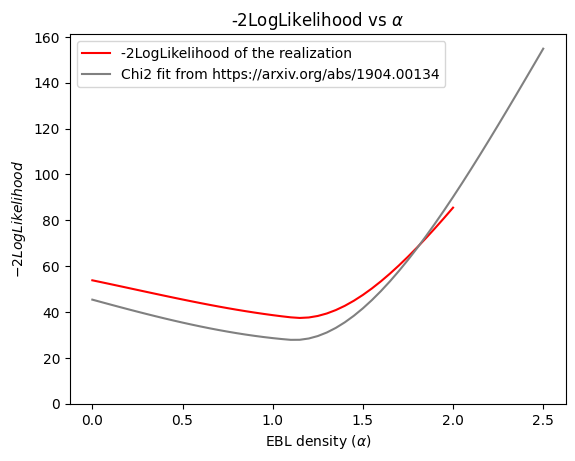

In [43]:
file2 = uproot.open("Output_fitebl.root:Chi2_1ES1011_Feb2014_LP")
magicalphas = file2.values()[0]
magichis = file2.values()[1]

iteration_order = 4
alphas_iter2 = np.array(alphas_iter)[0]# alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
chisqs_iter2 = np.array(chisqs_iter)[iteration_order]# chisqs_iter2 = np.concatenate(chisqs_iter)
order = np.argsort(alphas_iter[0])
alphas = alphas_iter[0]


fig, ax = plt.subplots()
ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(chisqs_iter2, order, axis=0), color = "red", label="-2LogLikelihood of the realization")
# h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),100], norm = colors.LogNorm(), cmap = "rainbow", label="histogram of -2LogLikelihood values")
# ax.plot(alphas_iter2, chisqs_iter2)
ax.plot(magicalphas, magichis, color = "grey", label= "Chi2 fit from https://arxiv.org/abs/1904.00134")
ax.set_xlabel(r'EBL density ($\alpha$)')
ax.set_ylabel(r'$-2LogLikelihood$')
ax.legend()
ax.set_ylim(bottom = 0)
# ax.set_xlim(0.5,1.15)
# fig.colorbar(h[3], ax=ax, label="number of times")
ax.set_title(r"-2LogLikelihood vs $\alpha$")
plt.show()

In [44]:
def extract_data(ds):
    Non = ds['Non'][:]
    Noff = ds['Noff'][:]
    Non_u = ds['Non_u'][:]
    Noff_u = ds['Noff_u'][:]
    return Non, Non_u, Noff, Noff_u

In [45]:
iter_plot = 1061 #check that simu has been run
fit_f = "LP"
sim_f = "PWL"
fit_func = fit_func_select(fit_f, knots, Efirst, DeltaEbr)
alpha = 0.1

loc = Path('/home/rgrau/Desktop/EBL-splines/EBL1000_{0}_{1}_MAGIC_with_0.07_Systematics_4w_fix_2'.format(sim_f, fit_f))
fileop = h5py.File("{0}/bestfit_iter_{1}/alpha_{2}.hdf5".format(loc, iter_plot, alpha), "r")
if 'fit' in fileop:
    fit_results = fileop['fit'][:]
file_data = h5py.File("{0}/simdata/iter_{1}.hdf5".format(loc, iter_plot), "r")
Non, Non_u, Noff, Noff_u = extract_data(file_data)

/tmp/ipykernel_18470/4020308859.py:30: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(E_forplot, (Non[minbin:maxbin] - Non_nonP) / Non_nonP , yerr= Non_u[minbin:maxbin] / Non_nonP, fmt = "_",  color = "black")


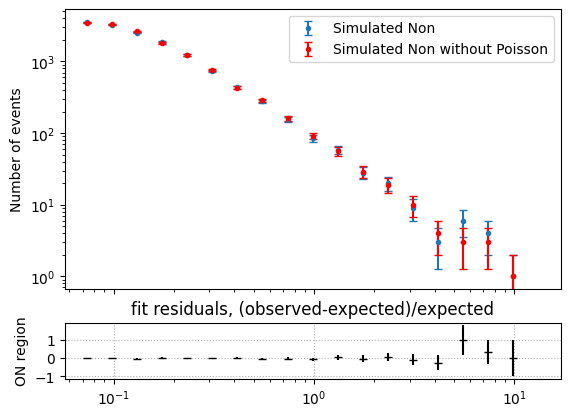

In [46]:
tau = tau_interp(xdata, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, xdata)
Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
minbin = Usedbins[0][0]
maxbin = Usedbins[0][-1] + 1
E_forplot = Eest[minbin:maxbin]
mtau = -tau
mu_gam = dNdE_to_mu_MAGIC((fit_func(xdata, fit_results) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, Eest)
mu_gam_final = mu_gam[minbin:maxbin]
mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
mu_bg_final = mu_bg[minbin:maxbin]
mu_on_sim = mu_gam_final + mu_bg_final

Non_nonP = np.round(mu_on[minbin:maxbin])
Non_nonP_u = np.sqrt(Non_nonP)

mu_gam_bestfit = dNdE_to_mu_MAGIC(fit_func(Etrue, fit_results) * np.exp(-tau_interp(Etrue, Source_z, EBL_Model, kind_of_interp = "log") * alpha), Ebinsw_Etrue, migmatval, Eest)
Non_bestfit = (mu_gam_bestfit + mu_BG(mu_gam_bestfit, Non, Noff, Noffregions))[minbin:maxbin]

#f, ax1 = plt.subplots()
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(E_forplot, Non[minbin:maxbin], yerr=Non_u[minbin:maxbin], fmt = ".", label = "Simulated Non", capsize = 3)
ax1.errorbar(E_forplot, Non_nonP, yerr = Non_nonP_u, fmt = ".", label = "Simulated Non without Poisson", capsize = 3, color = "red")
# ax1.plot(E_forplot, Non_bestfit, label = "best fit Non")
# ax1.scatter(E_forplot, mu_on_sim, marker = ".", label = "Fitted Non ", color = 'orange')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel("Number of events")
ax1.legend()

ax2.errorbar(E_forplot, (Non[minbin:maxbin] - Non_nonP) / Non_nonP , yerr= Non_u[minbin:maxbin] / Non_nonP, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("ON region")
ax2.grid(linestyle = ":")
# ax2.errorbar(Eest_final, (Non[9:24] - mu_on_sim) / mu_on_sim, yerr = Non_u[9:24]/mu_on_sim, fmt = ".", capsize = 3)


# ax2.errorbar(Eest_final, (Non[minbin:maxbin] - Non_nonP) / Non_nonP, yerr = 0, fmt = ".", capsize = 3, color = "red")
# ax2.axhline(color = "black")
# ax2.set_xlabel("Energy (TeV)")
# ax2.set_title("residuals")
# ax2.set_ylabel("Number of events")
plt.show()

/tmp/ipykernel_18470/3399260983.py:31: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(E_forplot, (Noff[minbin:maxbin] - Noff_nonP) / Noff_nonP , yerr= Noff_u[minbin:maxbin] / Noff_nonP, fmt = "_",  color = "black")


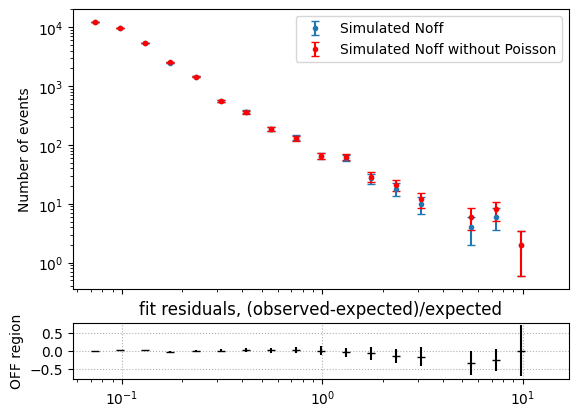

In [47]:
# Non[9:24]
# Noff[9:24]
# Non_u[9:24]
# Noff_u[9:24]
tau = tau_interp(xdata, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, xdata)
Usedbins = np.where((Emin <= Eest) & (Eest <= Emax))
minbin = Usedbins[0][0]
maxbin = Usedbins[0][-1] + 1
E_forplot = Eest[minbin:maxbin]
mtau = -tau
mu_gam = dNdE_to_mu_MAGIC((fit_func(xdata, fit_results) * np.exp(mtau * alpha)), Ebinsw_Etrue, migmatval, Eest)
mu_gam_final = mu_gam[minbin:maxbin]
mu_bg = mu_BG(mu_gam, Non, Noff, Noffregions)
mu_bg_final = mu_bg[minbin:maxbin]
mu_on_sim = mu_gam_final + mu_bg_final

Noff_nonP = np.round(4 * mu_bg[minbin:maxbin])
Noff_nonP_u = np.sqrt(Noff_nonP)

#f, ax1 = plt.subplots()
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
ax1.errorbar(E_forplot, Noff[minbin:maxbin], yerr=Noff_u[minbin:maxbin], fmt = ".", label = "Simulated Noff", capsize = 3)
ax1.errorbar(E_forplot, Noff_nonP, yerr = Noff_nonP_u, fmt = ".", label = "Simulated Noff without Poisson", capsize = 3, color = "red")
# ax1.plot(E_forplot, Non_bestfit, label = "best fit Non")
# ax1.scatter(E_forplot, mu_on_sim, marker = ".", label = "Fitted Non ", color = 'orange')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel("Number of events")
ax1.legend()

ax2.errorbar(E_forplot, (Noff[minbin:maxbin] - Noff_nonP) / Noff_nonP , yerr= Noff_u[minbin:maxbin] / Noff_nonP, fmt = "_",  color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("OFF region")
ax2.grid(linestyle = ":")

plt.show()

SED Approximation

/tmp/ipykernel_18470/2598325818.py:3: RuntimeWarning: invalid value encountered in true_divide
  SED_sim = SED_orig * Non[minbin:maxbin] / Non_nonP


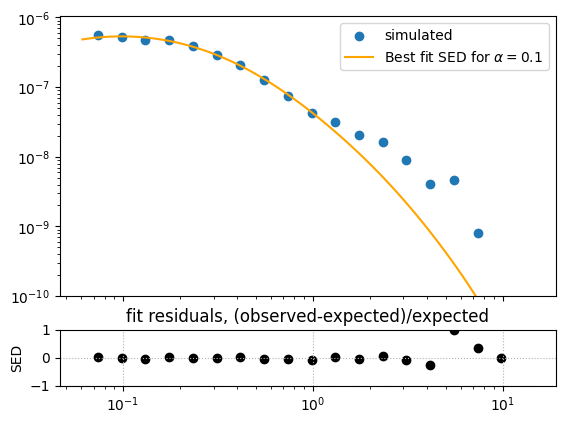

In [48]:
tau = tau_interp(E_forplot, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, Eest_final)
SED_orig = dNdE_absorbed(Source_flux, E_forplot, Norm, Ph_index, LP_curvature, tau) *E_forplot *E_forplot
SED_sim = SED_orig * Non[minbin:maxbin] / Non_nonP
tau_fit = tau_interp(Etrue, Source_z, EBL_Model, kind_of_interp = "log")#log_interp1d(E_EBL, tau_EBL, Etrue)
SED_fit = fit_func(Etrue, fit_results) * Etrue * Etrue * np.exp(-tau_fit * alpha)
Etrue_bins = np.where((Emin <= Etrue) & (Etrue <= Emax))
minbin_tr = Etrue_bins[0][0]
maxbin_tr = Etrue_bins[0][-1] + 1

f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]}, sharex=True)

#ax1.scatter(E_forplot, SED_orig, label = "original")
ax1.scatter(E_forplot, SED_sim, label = "simulated")
ax1.plot(Etrue[minbin_tr:maxbin_tr], SED_fit[minbin_tr:maxbin_tr], label = r"Best fit SED for $\alpha = ${0}".format(alpha), color = 'orange')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(ymin = 1e-10)
ax1.legend()

ax2.scatter(E_forplot, (SED_sim - SED_orig) / SED_orig, color = "black")
# ax2.axhline(color = "black")
ax2.set_title("fit residuals, (observed-expected)/expected")
ax2.set_ylabel("SED")
ax2.grid(linestyle = ":")
ax2.set_ylim(ymin = -1, ymax = 1)

plt.show()